# 预测股价涨跌概率

## 简介

最终结果肯定是想要预测出股价范围，以及是涨是跌，最好是能做高频，带着实验性的目的开始进行尝试

参数列表
* 占位

短期目标：
建立一个模型来预测每个测试集的涨跌可能性。我们会采用逻辑回归，决策树，随机森林，神经网络和SVM算法来分别建立模型，并选择相对优秀的模型来预测测试集。

## 特征转换

我们首先读入所有数据，并检查有无缺失值。然后划分训练集测试集。

In [1]:
#读入训练集数据
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns


%matplotlib inline
plt.style.use('ggplot')
plt.figure(figsize=(20, 12))

all_data = pd.read_csv('../../data/000016_6_8_m1.csv')
all_data = all_data.copy()

# 检查缺失值
miss_n = all_data.isnull().sum()
print(miss_n)

taget             0
date              0
day               0
times             0
open              0
high              0
low               0
close             0
volume            0
MA.MA1            0
MA.MA2            0
MA.MA3            0
MA.MA4            0
VOL-TDX.VOLUME    0
VOL-TDX.MAVOL1    0
VOL-TDX.MAVOL2    0
MACD.DIF          0
MACD.DEA          0
MACD.MACD         0
dtype: int64


<Figure size 2000x1200 with 0 Axes>

目前上述无缺失，接下来我们最好检查一下是否存在共线性的特征，通过绘制各个特征之间相关性的方法；

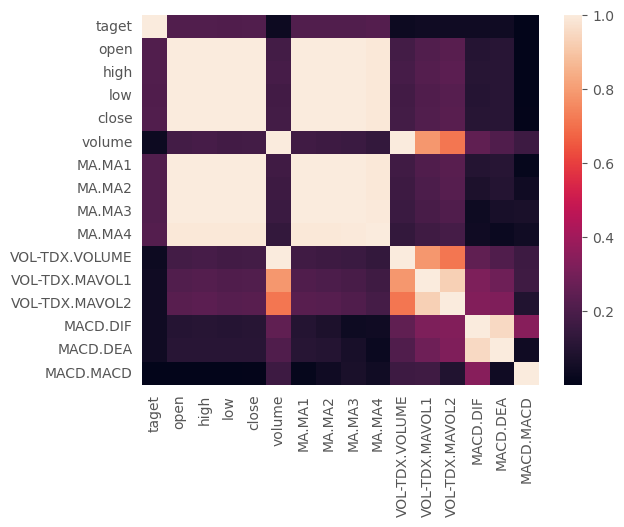

In [2]:
#绘出各个特征之间相关系数
corrmat = all_data.corr(numeric_only=True).abs()
sns.heatmap(corrmat)
plt.show()

根据上图其实可以看出有多个特征存在共线性关系，需要将其剔除。

In [3]:
# 去除共线性特征
all_data = all_data.drop(
    ['open', 'high', 'low', 'MA.MA1', 'MA.MA2', 'MA.MA3', 'MA.MA4', 'VOL-TDX.MAVOL1', 'VOL-TDX.MAVOL2',
     'VOL-TDX.VOLUME', 'MACD.DEA', 'MACD.DIF'], axis=1)
all_data


,taget,date,day,times,close,volume,MACD.MACD
0,202306010931,2023/06/01 09:31,2023/6/1,9:31,2491.63,143942,-0.98
1,202306010932,2023/06/01 09:32,2023/6/1,9:32,2492.88,62464,-0.96
2,202306010933,2023/06/01 09:33,2023/6/1,9:33,2495.94,59204,-0.50
3,202306010934,2023/06/01 09:34,2023/6/1,9:34,2499.27,53532,0.24
4,202306010935,2023/06/01 09:35,2023/6/1,9:35,2499.52,50619,0.72
...,...,...,...,...,...,...,...
15355,202308311456,2023/08/31 14:56,2023/8/31,14:56,2511.51,32344,-0.72
15356,202308311457,2023/08/31 14:57,2023/8/31,14:57,2510.93,29468,-0.79
15357,202308311458,2023/08/31 14:58,2023/8/31,14:58,2511.22,1428,-0.76
15358,202308311459,2023/08/31 14:59,2023/8/31,14:59,2511.22,0,-0.69


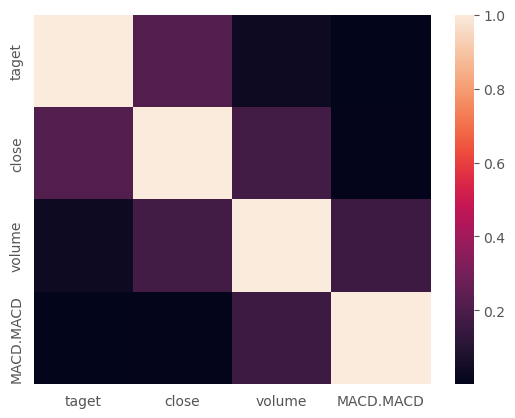

In [4]:
corrmat = all_data.corr(numeric_only=True).abs()
sns.heatmap(corrmat)
plt.show()

In [5]:
train_size = all_data.shape[0] // 10 * 6
test_size = (all_data.shape[0] - train_size) // 2
valid_size = all_data.shape[0] - test_size
# print(train_size, test_size, valid_size, train_size + valid_size + test_size, all_data.shape[0])
train = all_data[:train_size].copy()
test = all_data[train_size:train_size + test_size].copy()
valid = all_data[valid_size:].copy()

# print(train.shape, test.shape, valid.shape)
# print(train.head, test.head, valid.head)
print("Output：当前一共读取%s条数据，其中训练集使用%s条数据，测试集使用%s条数据，验证集使用%s条数据" % (
    all_data.shape[0], train.shape[0], test.shape[0], valid.shape[0]))


Output：当前一共读取15360条数据，其中训练集使用9216条数据，测试集使用3072条数据，验证集使用3072条数据


<Axes: >

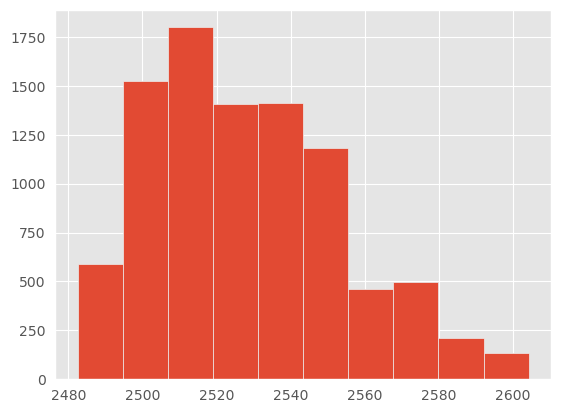

In [6]:
train['close'].hist()

无论是从理论知识还是柱状图我们都能看出来股价跨度还是比较大的，我们需要将其标准化，targets可以考虑在这步删除。


In [7]:
# 标准化价格
# train['normalized_price'] = (train['close'] - train['close'].mean()) / (train['close'].std())
# train


In [8]:
# 用sklearn库计算
scaler = StandardScaler()
train['normalized_price'] = scaler.fit_transform(train['close'].values.reshape(-1, 1))

train


,taget,date,day,times,close,volume,MACD.MACD,normalized_price
0,202306010931,2023/06/01 09:31,2023/6/1,9:31,2491.63,143942,-0.98,-1.428277
1,202306010932,2023/06/01 09:32,2023/6/1,9:32,2492.88,62464,-0.96,-1.379348
2,202306010933,2023/06/01 09:33,2023/6/1,9:33,2495.94,59204,-0.50,-1.259570
3,202306010934,2023/06/01 09:34,2023/6/1,9:34,2499.27,53532,0.24,-1.129223
4,202306010935,2023/06/01 09:35,2023/6/1,9:35,2499.52,50619,0.72,-1.119437
...,...,...,...,...,...,...,...,...
9211,202307271102,2023/07/27 11:02,2023/7/27,11:02,2587.31,13416,-0.82,2.316952
9212,202307271103,2023/07/27 11:03,2023/7/27,11:03,2588.36,12644,-0.50,2.358053
9213,202307271104,2023/07/27 11:04,2023/7/27,11:04,2588.14,10775,-0.28,2.349441
9214,202307271105,2023/07/27 11:05,2023/7/27,11:05,2587.30,10812,-0.21,2.316561


---


In [9]:
#首先设置忽略warnings
import warnings

warnings.filterwarnings('ignore')

In [10]:
#逻辑回归算法来训练模型
from sklearn.model_selection import cross_val_predict
# from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
train = train.copy()
#设置惩罚因子，我们加重惩罚错误预测为1的
penalty = {
    0: 1,
    1: 3.6
}


#实例化模型对象:
lr = LinearRegression()
features = train.columns.drop(["normalized_price","date","day","times","taget"])
print(features)
# features = train.columns
lr.fit(train[features], train['normalized_price'])
#
#使用5重交叉验证进行预测
fitted_labels = cross_val_predict(lr, train[features], train['normalized_price'], cv=5)
train['fitted_labels'] = fitted_labels

train

Index(['close', 'volume', 'MACD.MACD'], dtype='object')


,taget,date,day,times,close,volume,MACD.MACD,normalized_price,fitted_labels
0,202306010931,2023/06/01 09:31,2023/6/1,9:31,2491.63,143942,-0.98,-1.428277,-1.428277
1,202306010932,2023/06/01 09:32,2023/6/1,9:32,2492.88,62464,-0.96,-1.379348,-1.379348
2,202306010933,2023/06/01 09:33,2023/6/1,9:33,2495.94,59204,-0.50,-1.259570,-1.259570
3,202306010934,2023/06/01 09:34,2023/6/1,9:34,2499.27,53532,0.24,-1.129223,-1.129223
4,202306010935,2023/06/01 09:35,2023/6/1,9:35,2499.52,50619,0.72,-1.119437,-1.119437
...,...,...,...,...,...,...,...,...,...
9211,202307271102,2023/07/27 11:02,2023/7/27,11:02,2587.31,13416,-0.82,2.316952,2.316952
9212,202307271103,2023/07/27 11:03,2023/7/27,11:03,2588.36,12644,-0.50,2.358053,2.358053
9213,202307271104,2023/07/27 11:04,2023/7/27,11:04,2588.14,10775,-0.28,2.349441,2.349441
9214,202307271105,2023/07/27 11:05,2023/7/27,11:05,2587.30,10812,-0.21,2.316561,2.316561
